In [60]:
import spacy
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec, FastText
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,LSTM, GRU, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import time
import random

In [61]:
df = pd.read_excel("/kaggle/input/students-anxiety-and-depression-dataset/dataset.xlsx")
df.dropna(subset=['text'], inplace=True)
df.head()

,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless hear...",1.0
2,"All wrong, back off dear, forward doubt. Stay ...",1.0
3,I've shifted my focus to something else but I'...,1.0
4,"I'm restless and restless, it's been a month n...",1.0


# Task 1

**Preprocessing**

In [62]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    if isinstance(text, str): 
        doc = nlp(text.lower()) 
        tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
        return " ".join(tokens)
    return ""

if "text" in df.columns:
    df = df.dropna(subset=["text"]).copy()  # remove NaN 
    df.loc[:, "processed_text"] = df["text"].apply(preprocess_text)
else:
    raise ValueError("The dataset does not contain a 'text' column.")

print(df.head())

                                                text  label  \
0                                         oh my gosh    1.0   
1  trouble sleeping, confused mind, restless hear...    1.0   
2  All wrong, back off dear, forward doubt. Stay ...    1.0   
3  I've shifted my focus to something else but I'...    1.0   
4  I'm restless and restless, it's been a month n...    1.0   

                                      processed_text  
0                                            oh gosh  
1    trouble sleep confused mind restless heart tune  
2  wrong dear forward doubt stay restless restles...  
3                                shift focus worried  
4                   restless restless month boy mean  



**Train Word2Vec (CBOW and Skip-gram)/FastText**

In [63]:
tokenized_sentences = [text.split() for text in df["processed_text"]]

w2v_cbow = Word2Vec(sentences=tokenized_sentences, vector_size=50, window=5, min_count=1, sg=0)
w2v_sg = Word2Vec(sentences=tokenized_sentences, vector_size=50, window=5, min_count=1, sg=1)
fasttext_model = FastText(sentences=tokenized_sentences, vector_size=50, window=5, min_count=1)

In [64]:
def check_most_similar(model, word):
    if word in model.wv:
        return model.wv.most_similar(word)
    else:
        return f"'{word}' not in vocabulary."

In [65]:
print("CBOW:", check_most_similar(w2v_cbow, "restless"))
print("Skip-gram:", check_most_similar(w2v_sg, "restless"))
print("FastText:", check_most_similar(fasttext_model, "restless"))

CBOW: [('think', 0.9922728538513184), ('today', 0.991673469543457), ('heart', 0.9913752675056458), ('wait', 0.9912312030792236), ('want', 0.9910931587219238), ('turn', 0.9909637570381165), ('sad', 0.9908695220947266), ('like', 0.9906551837921143), ('know', 0.9905816316604614), ('feel', 0.9903585314750671)]
Skip-gram: [('anxious', 0.995615541934967), ('sad', 0.9952038526535034), ('nervous', 0.9943444132804871), ('heart', 0.9942732453346252), ('feel', 0.9940941333770752), ('know', 0.9936734437942505), ('suddenly', 0.9935982823371887), ('night', 0.9934685826301575), ('worried', 0.9933236837387085), ('day', 0.992883563041687)]
FastText: [('restlessness', 0.9999955296516418), ('restlessly', 0.9999932646751404), ('rest', 0.9999831318855286), ('countless', 0.999982476234436), ('ress', 0.9999793767929077), ('heart', 0.9999792575836182), ('content', 0.9999790191650391), ('restive', 0.9999778270721436), ('religion', 0.9999775886535645), ('consultation', 0.9999774098396301)]


In [66]:
df = df.dropna(subset=["label"])

vectorizer = TfidfVectorizer()#conver text to TF-IDF vectors
X = vectorizer.fit_transform(df["processed_text"])
y = df["label"]

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [69]:
y_pred = model.predict(X_test)

In [70]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9505021520803444


In [71]:
glove_embeddings = {}
with open("/kaggle/input/glove-6b-100d-txtt/glove.6B.100d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

**Extract word vectors for common words**

In [72]:
common_words = list(w2v_cbow.wv.index_to_key)[:15]
w2v_cbow_vectors = np.array([w2v_cbow.wv[word] for word in common_words])
w2v_sg_vectors = np.array([w2v_sg.wv[word] for word in common_words])
fasttext_vectors = np.array([fasttext_model.wv[word] for word in common_words])
glove_vectors = np.array([glove_embeddings[word] for word in common_words if word in glove_embeddings])

**t-SNE**

In [73]:
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
w2v_cbow_tsne = tsne.fit_transform(w2v_cbow_vectors)
w2v_sg_tsne = tsne.fit_transform(w2v_sg_vectors)
fasttext_tsne = tsne.fit_transform(fasttext_vectors)
glove_tsne = tsne.fit_transform(glove_vectors)

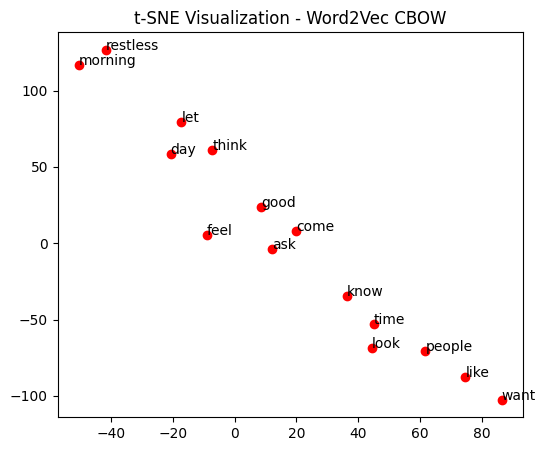

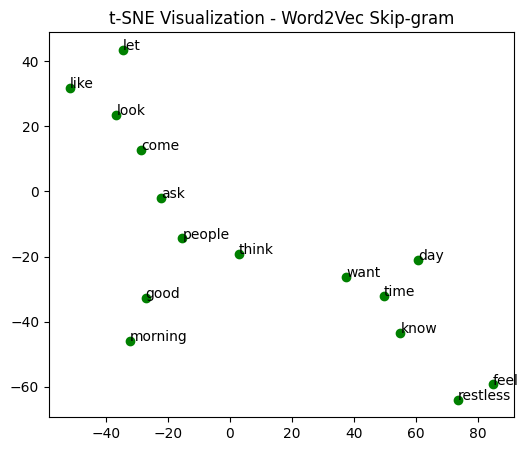

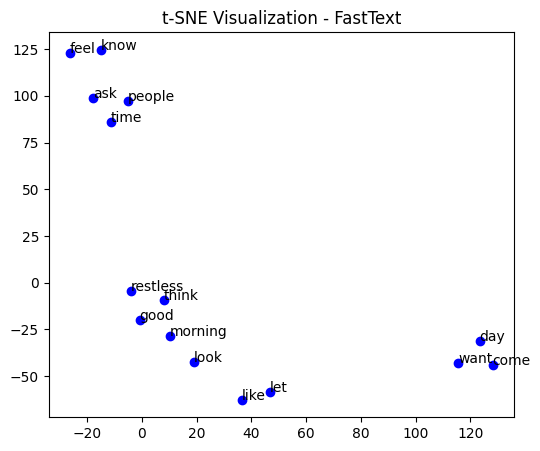

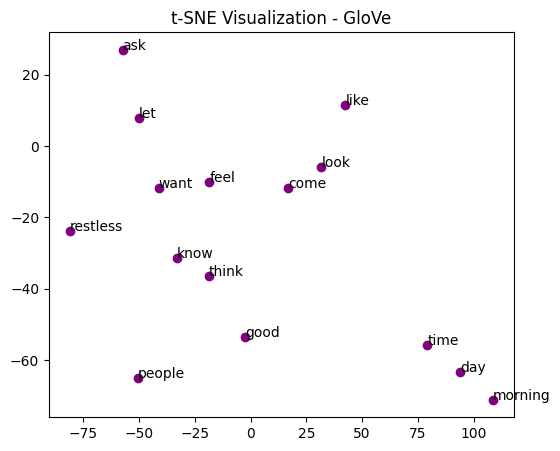

In [74]:
def plot_embeddings(embeddings, words, title, color):
    plt.figure(figsize=(6, 5))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], color=color)
    for i, word in enumerate(words):
        plt.annotate(word, xy=(embeddings[i, 0], embeddings[i, 1]))
    plt.title(title)
    plt.show()
plot_embeddings(w2v_cbow_tsne, common_words, "t-SNE Visualization - Word2Vec CBOW", 'red')
plot_embeddings(w2v_sg_tsne, common_words, "t-SNE Visualization - Word2Vec Skip-gram", 'green')
plot_embeddings(fasttext_tsne, common_words, "t-SNE Visualization - FastText", 'blue')
plot_embeddings(glove_tsne, common_words[:len(glove_tsne)], "t-SNE Visualization - GloVe", 'purple')

**PCA**

In [75]:
def apply_pca(model, words, n_components=2):
    word_vectors = np.array([model.wv[word] for word in words if word in model.wv])
    pca = PCA(n_components=n_components)
    reduced_vectors = pca.fit_transform(word_vectors)
    return reduced_vectors


w2v_cbow_pca = apply_pca(w2v_cbow, common_words)
w2v_sg_pca = apply_pca(w2v_sg, common_words)
fasttext_pca = apply_pca(fasttext_model, common_words)
glove_pca = np.array([glove_embeddings[word] for word in common_words if word in glove_embeddings])
glove_pca = PCA(n_components=2).fit_transform(glove_pca)

def plot_pca(embeddings, words, title, color):
    plt.figure(figsize=(6, 5))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], color=color)
    for i, word in enumerate(words):
        plt.annotate(word, xy=(embeddings[i, 0], embeddings[i, 1]))
    plt.title(title)
    plt.show()


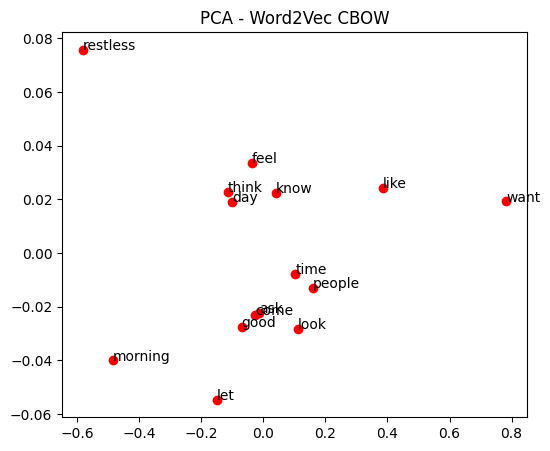

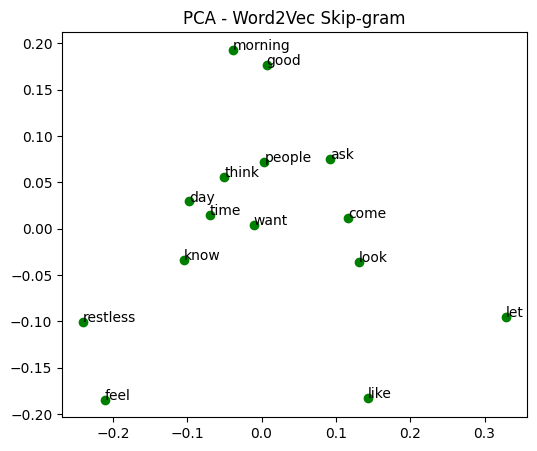

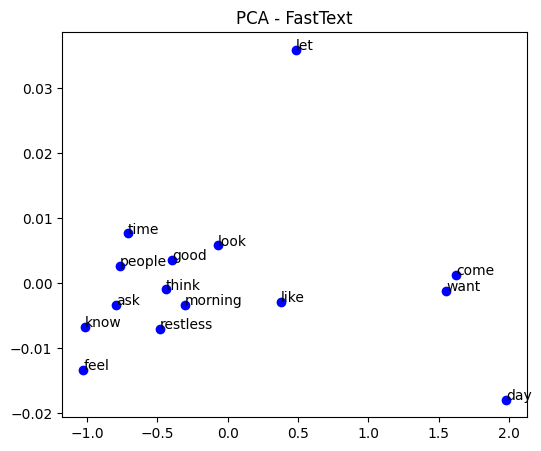

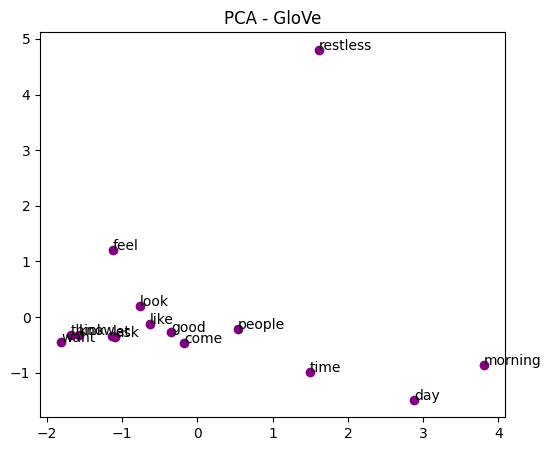

In [76]:
plot_pca(w2v_cbow_pca, common_words, "PCA - Word2Vec CBOW", 'red')
plot_pca(w2v_sg_pca, common_words, "PCA - Word2Vec Skip-gram", 'green')
plot_pca(fasttext_pca, common_words, "PCA - FastText", 'blue')
plot_pca(glove_pca, common_words[:len(glove_pca)], "PCA - GloVe", 'purple')

**Cosine similarity**

In [77]:
from scipy.spatial.distance import cosine

def get_cosine_similarity(model, word1, word2):
    if word1 in model.wv and word2 in model.wv:
        return 1 - cosine(model.wv[word1], model.wv[word2])
    else:
        return None 


similarity_cbow = get_cosine_similarity(w2v_cbow, "fast", "quick")
similarity_skipgram = get_cosine_similarity(w2v_sg, "fast", "quick")
similarity_fasttext = get_cosine_similarity(fasttext_model, "fast", "quick")
similar_cbow = get_cosine_similarity(w2v_cbow, "restless", "anxious")
similar_skipgram = get_cosine_similarity(w2v_sg, "restless", "anxious")
similar_fasttext = get_cosine_similarity(fasttext_model, "restless", "anxious")


In [78]:
word_pairs = [("happy", "joy"), ("sad", "unhappy"), ("restless", "anxious"), ("fast", "quick")]

cosine_similarities = {}
for word1, word2 in word_pairs:
    cosine_similarities[(word1, word2)] = {
        "Word2Vec CBOW": get_cosine_similarity(w2v_cbow, word1, word2),
        "Word2Vec Skip-gram": get_cosine_similarity(w2v_sg, word1, word2),
        "FastText": get_cosine_similarity(fasttext_model, word1, word2),
        "GloVe": 1 - cosine(glove_embeddings[word1], glove_embeddings[word2]) if word1 in glove_embeddings and word2 in glove_embeddings else None
    }


In [79]:
print("FAST AND QUICK" )
print("Word2Vec CBOW similarity:", similarity_cbow)
print("Word2Vec Skip-gram similarity:", similarity_skipgram)
print("FastText similarity:", similarity_fasttext)
print("RESTLESS AND ANXIOUS" )
print("Word2Vec CBOW similarity:", similar_cbow)
print("Word2Vec Skip-gram similarity:", similar_skipgram)
print("FastText similarity:", similar_fasttext)

FAST AND QUICK
Word2Vec CBOW similarity: -0.03591533589838103
Word2Vec Skip-gram similarity: 0.8187095438454863
FastText similarity: 0.9998690090937873
RESTLESS AND ANXIOUS
Word2Vec CBOW similarity: 0.9887201254050633
Word2Vec Skip-gram similarity: 0.9956155962734357
FastText similarity: 0.9999486457652814


In [80]:
cosine_df = pd.DataFrame(list(cosine_similarities.items()), columns=["Model", "Cosine Similarity"])
display(cosine_df)

,Model,Cosine Similarity
0,"(happy, joy)","{'Word2Vec CBOW': 0.8213620217598375, 'Word2Ve..."
1,"(sad, unhappy)","{'Word2Vec CBOW': None, 'Word2Vec Skip-gram': ..."
2,"(restless, anxious)","{'Word2Vec CBOW': 0.9887201254050633, 'Word2Ve..."
3,"(fast, quick)","{'Word2Vec CBOW': -0.03591533589838103, 'Word2..."


# Task2 - RNN for Sentiment Analysis

In [82]:
MAX_VOCAB_SIZE = 5000
MAX_SEQUENCE_LENGTH = 100

**Tokenization & Padding**

In [83]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df["processed_text"])
sequences = tokenizer.texts_to_sequences(df["processed_text"])
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
y = df["label"].values

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Build RNN Model**

In [85]:
rnn_model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128),
    SimpleRNN(64, return_sequences=False),
    Dense(1, activation="sigmoid")
])

rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [86]:
print("Training RNN model...")
history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

Training RNN model...
Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.8904 - loss: 0.3840 - val_accuracy: 0.8859 - val_loss: 0.3551
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8903 - loss: 0.3465 - val_accuracy: 0.8859 - val_loss: 0.3580
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9030 - loss: 0.3201 - val_accuracy: 0.8859 - val_loss: 0.3561
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8916 - loss: 0.3448 - val_accuracy: 0.8859 - val_loss: 0.3559
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8956 - loss: 0.3350 - val_accuracy: 0.8859 - val_loss: 0.3575
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9011 - loss: 0.3236 - val_accuracy: 0.8859 - val_loss: 0.3565
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8990 - loss: 0.3300 - val_accuracy: 0.8859 - val_loss: 0.3614
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8948 - loss: 0.3380 - va

**Plot Accuracy & Loss Curves**

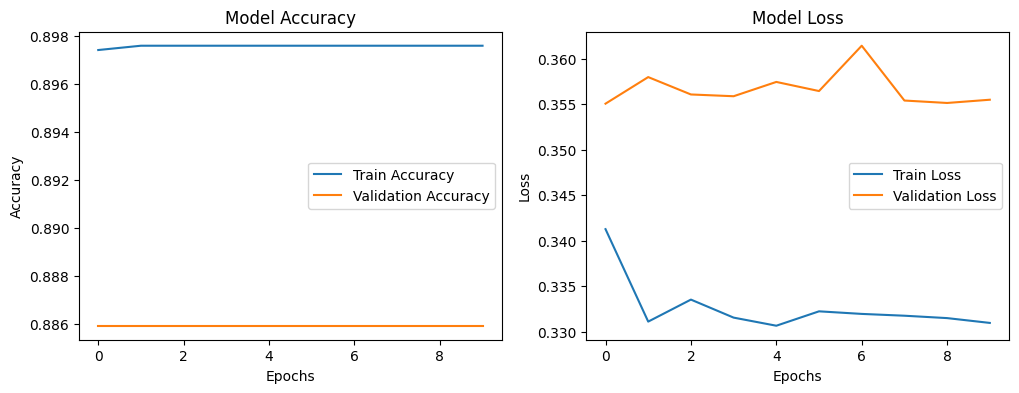

In [87]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

**Vanishing Gradient Demonstration**

In [88]:
print("Analyzing vanishing gradient problem...")

def get_gradients(rnn_model, X_sample, y_sample):
    with tf.GradientTape() as tape:
        inputs = tf.convert_to_tensor(X_sample, dtype=tf.float32)
        tape.watch(inputs)
        predictions = rnn_model(inputs, training=True)
        loss = tf.keras.losses.binary_crossentropy(tf.reshape(y_sample, (-1, 1)), predictions)  # Fix here

    grads = tape.gradient(loss, rnn_model.trainable_variables)
    return grads

Analyzing vanishing gradient problem...


**Compute gradients**

In [90]:
X_sample, y_sample = X_train[:1], y_train[:1]
gradients = get_gradients(rnn_model, X_sample, y_sample)

**Plot gradients**

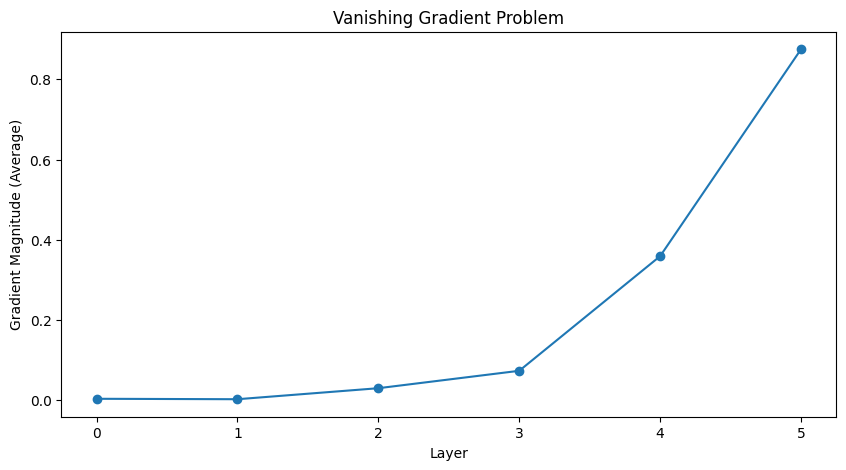

In [91]:
plt.figure(figsize=(10, 5))
plt.plot([np.mean(np.abs(grad.values.numpy())) if isinstance(grad, tf.IndexedSlices)
          else np.mean(np.abs(grad.numpy())) for grad in gradients], marker="o")
plt.title("Vanishing Gradient Problem")
plt.xlabel("Layer")
plt.ylabel("Gradient Magnitude (Average)")
plt.show()

# Task 3 - LSTM and GRU Comparison

In [92]:
print("Training LSTM model...")

lstm_model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128),
    LSTM(64, return_sequences=False),
    Dense(1, activation="sigmoid")
])

lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss="binary_crossentropy", metrics=["accuracy"])

start_time = time.time()
history_lstm = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)
lstm_time = time.time() - start_time

Training LSTM model...
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8948 - loss: 0.3857 - val_accuracy: 0.8859 - val_loss: 0.3573
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8960 - loss: 0.3357 - val_accuracy: 0.8859 - val_loss: 0.3553
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8966 - loss: 0.3331 - val_accuracy: 0.8859 - val_loss: 0.3581
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8976 - loss: 0.3316 - val_accuracy: 0.8859 - val_loss: 0.3553
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8937 - loss: 0.3390 - val_accuracy: 0.8859 - val_loss: 0.3549
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8915 - loss: 0.3429 - val_accuracy: 0.8859 - val_loss: 0.3564
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8989 - loss: 0.3291 - val_accuracy: 0.8859 - val_loss: 0.3575
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8997 - loss: 0.

In [93]:
print("Training GRU model...")

gru_model = Sequential([
     Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128),
    GRU(64, return_sequences=False),
    Dense(1, activation="sigmoid")
])

gru_model.compile(optimizer=Adam(learning_rate=0.0005), loss="binary_crossentropy", metrics=["accuracy"])

start_time = time.time()
history_gru = gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)
gru_time = time.time() - start_time

Training GRU model...
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8757 - loss: 0.3937 - val_accuracy: 0.8859 - val_loss: 0.3552
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9010 - loss: 0.3242 - val_accuracy: 0.8859 - val_loss: 0.3551
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8969 - loss: 0.3330 - val_accuracy: 0.8859 - val_loss: 0.3559
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8937 - loss: 0.3404 - val_accuracy: 0.8859 - val_loss: 0.3612
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8939 - loss: 0.3395 - val_accuracy: 0.8859 - val_loss: 0.3623
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8999 - loss: 0.3261 - val_accuracy: 0.8859 - val_loss: 0.3554
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9002 - loss: 0.3250 - val_accuracy: 0.8859 - val_loss: 0.3558
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8992 - loss: 0.3

# LSTM vs GRU Comparison: Training Accuracy & Loss

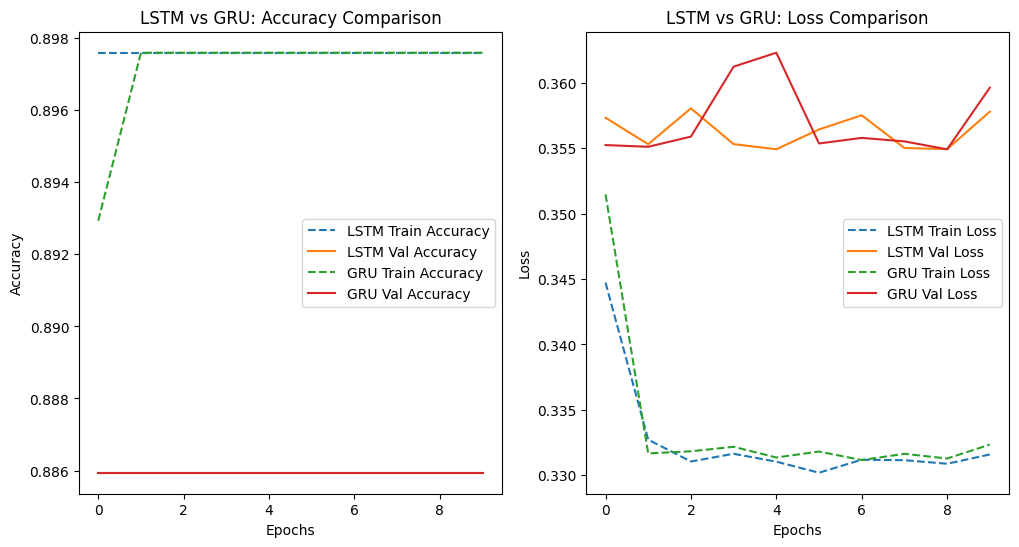

In [94]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # accuracy comparison
plt.plot(history_lstm.history["accuracy"], label="LSTM Train Accuracy", linestyle="--")
plt.plot(history_lstm.history["val_accuracy"], label="LSTM Val Accuracy", linestyle="-")
plt.plot(history_gru.history["accuracy"], label="GRU Train Accuracy", linestyle="--")
plt.plot(history_gru.history["val_accuracy"], label="GRU Val Accuracy", linestyle="-")
plt.title("LSTM vs GRU: Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


plt.subplot(1, 2, 2)# loss comparis
plt.plot(history_lstm.history["loss"], label="LSTM Train Loss", linestyle="--")
plt.plot(history_lstm.history["val_loss"], label="LSTM Val Loss", linestyle="-")
plt.plot(history_gru.history["loss"], label="GRU Train Loss", linestyle="--")
plt.plot(history_gru.history["val_loss"], label="GRU Val Loss", linestyle="-")
plt.title("LSTM vs GRU: Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

**Performance Report**

In [95]:
performance_report = pd.DataFrame({
    "Model": ["LSTM", "GRU"],
    "Training Time (seconds)": [ lstm_time, gru_time],
    "Final Train Accuracy": [
        history_lstm.history["accuracy"][-1],
        history_gru.history["accuracy"][-1]
    ],
    "Final Val Accuracy": [
        history_lstm.history["val_accuracy"][-1],
        history_gru.history["val_accuracy"][-1]
    ],
    "Final Train Loss": [
        history_lstm.history["loss"][-1],
        history_gru.history["loss"][-1]
    ],
    "Final Val Loss": [
        history_lstm.history["val_loss"][-1],
        history_gru.history["val_loss"][-1]
    ]
})

print("\nPerformance Report:\n", performance_report)


Performance Report:
   Model  Training Time (seconds)  Final Train Accuracy  Final Val Accuracy  \
0  LSTM                14.709280              0.897597             0.88594   
1   GRU                14.936263              0.897597             0.88594   

   Final Train Loss  Final Val Loss  
0          0.331593        0.357799  
1          0.332346        0.359636  


# Task 4 - LSTM text generation

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import time
import random
from sklearn.model_selection import train_test_split

In [33]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
shakespeare_text = tf.keras.utils.get_file("shakespeare.txt", url)

with open(shakespeare_text, "r", encoding="utf-8") as f:
    text = f.read().lower()

text = text[:500000]
print("Shakespeare dataset loaded successfully!")

Shakespeare dataset loaded successfully!


**Preprocessing**

In [34]:
text = text.replace("\n", " ") 
sentences = text.split(". ") 

MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 30

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1


**Sequences (N-gram method)**

In [35]:
input_sequences = []
for line in sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Padding & Labels
X = pad_sequences(input_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
y = np.array([seq[-1] for seq in input_sequences])
y = tf.keras.utils.to_categorical(y, num_classes=total_words)

In [36]:
import gc
gc.collect()

5555

In [37]:
Dense(total_words, activation='softmax')
total_words = y.shape[1] 

**LSTM model**

In [38]:
lstm_model = Sequential([
    Embedding(total_words, 128, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(128),
    Dense(128, activation='relu'),
    Dense(total_words, activation='softmax')  # Fix: Use correct number of classes
])

lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Train LSTM Model

In [52]:
start_time = time.time()
history_lstm = lstm_model.fit(X, y, epochs=10, batch_size=32, verbose=1)
lstm_training_time = time.time() - start_time


Epoch 1/10
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.3916 - loss: 3.3536 - val_accuracy: 0.4783 - val_loss: 2.7720
Epoch 2/10
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.4459 - loss: 2.8656 - val_accuracy: 0.5019 - val_loss: 2.6262
Epoch 3/10
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.4779 - loss: 2.6493 - val_accuracy: 0.5440 - val_loss: 2.4832
Epoch 4/10
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.5203 - loss: 2.4414 - val_accuracy: 0.6185 - val_loss: 2.2303
Epoch 5/10
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.5769 - loss: 2.1400 - val_accuracy: 0.6496 - val_loss: 2.0646
Epoch 6/10
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.6135 - loss: 1.9286 - val_accuracy: 0.6765 - val_loss: 1.9834
Epoch 7/10
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.6355 - loss: 1.7840 - val_accuracy: 0.6985 - val_loss: 1.9348
Epoch 8/10
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.6608 -

**Text Generation Function**

In [55]:
def generate_text_lstm(model, seed_text, next_words=20, temperature=1.0, top_k=10):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=MAX_SEQUENCE_LENGTH-1, padding='pre')

        predictions = model.predict(token_list, verbose=0)[0]

    
        predictions = np.log(predictions + 1e-8) / temperature
        exp_preds = np.exp(predictions)
        probabilities = exp_preds / np.sum(exp_preds)

   
        top_k_indices = np.argsort(probabilities)[-top_k:]
        top_k_probs = probabilities[top_k_indices]
        top_k_probs /= np.sum(top_k_probs) 

        predicted_index = np.random.choice(top_k_indices, p=top_k_probs)
        output_word = tokenizer.index_word.get(predicted_index, "")

        if output_word:
            seed_text += " " + output_word
        else:
            break

    return seed_text



**Generate Sample Shakespearean Text**

In [56]:
print("\nGenerated with LSTM:\n", generate_text_lstm(lstm_model, "thou art", next_words=50, temperature=0.8, top_k=10))



Generated with LSTM:
 thou art art he's he's he's he's he's he's he's he's he's he's he's he's he's he's he's he's he's he's he's he's he's he's gloucester unto unto unto unto unto peace peace peace peace peace peace peace peace peace peace peace peace peace peace welcome uncle news news news news holy


# Task 5 - Bidirectional LSTM Model

In [42]:
MAX_VOCAB_SIZE = 5000 
MAX_SEQUENCE_LENGTH = 40 

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

X = pad_sequences(input_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
y = np.array([seq[-1] for seq in input_sequences])
y = tf.keras.utils.to_categorical(y, num_classes=total_words)

**biLSTM Model**

In [43]:
bi_lstm_model = Sequential([
    Embedding(total_words, 128, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(128, return_sequences=True)),  # Bi-directional LSTM
    Dropout(0.3),
    LSTM(128),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(total_words, activation='softmax')
])

bi_lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])


**Train the biLSTM Model**

In [53]:
start_time = time.time()
history_bilstm = bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=32, verbose=1
)
bi_lstm_training_time = time.time() - start_time

Epoch 1/10
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.0591 - loss: 5.8538 - val_accuracy: 0.1965 - val_loss: 4.4098
Epoch 2/10
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - accuracy: 0.1435 - loss: 4.3544 - val_accuracy: 0.2362 - val_loss: 4.0917
Epoch 3/10
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - accuracy: 0.1860 - loss: 4.0686 - val_accuracy: 0.2344 - val_loss: 3.9254
Epoch 4/10
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - accuracy: 0.2218 - loss: 3.8431 - val_accuracy: 0.2986 - val_loss: 3.6759
Epoch 5/10
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - accuracy: 0.2583 - loss: 3.5830 - val_accuracy: 0.4131 - val_loss: 3.2507
Epoch 6/10
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - accuracy: 0.3805 - loss: 3.0915 - val_accuracy: 0.5258 - val_loss: 2.8839
Epoch 7/10
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - accuracy: 0.4686 - loss: 2.7109 - val_accuracy: 0.5662 - val_loss: 2.7052
Epoch 8/10
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - accuracy: 0.5026 -

**Text Generation Using BiLSTM**

In [57]:
def generate_text_bilstm(model, seed_text, next_words=30, temperature=0.8, top_k=10):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=MAX_SEQUENCE_LENGTH-1, padding='pre')
        predictions = model.predict(token_list, verbose=0)[0]

        predictions = np.log(predictions + 1e-8) / temperature
        exp_preds = np.exp(predictions)
        probabilities = exp_preds / np.sum(exp_preds)

        top_k_indices = np.argsort(probabilities)[-top_k:]
        top_k_probs = probabilities[top_k_indices]
        top_k_probs /= np.sum(top_k_probs)  # Normalize

        predicted_index = np.random.choice(top_k_indices, p=top_k_probs)
        output_word = tokenizer.index_word.get(predicted_index, "")

        if output_word:
            seed_text += " " + output_word
        else:
            break

    return seed_text

**Generate Sample Shakespearean Text**

In [58]:
print("\nGenerated with biLSTM:\n", generate_text_bilstm(bi_lstm_model, "thou art", next_words=50, temperature=0.8, top_k=10))



Generated with biLSTM:
 thou art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art art


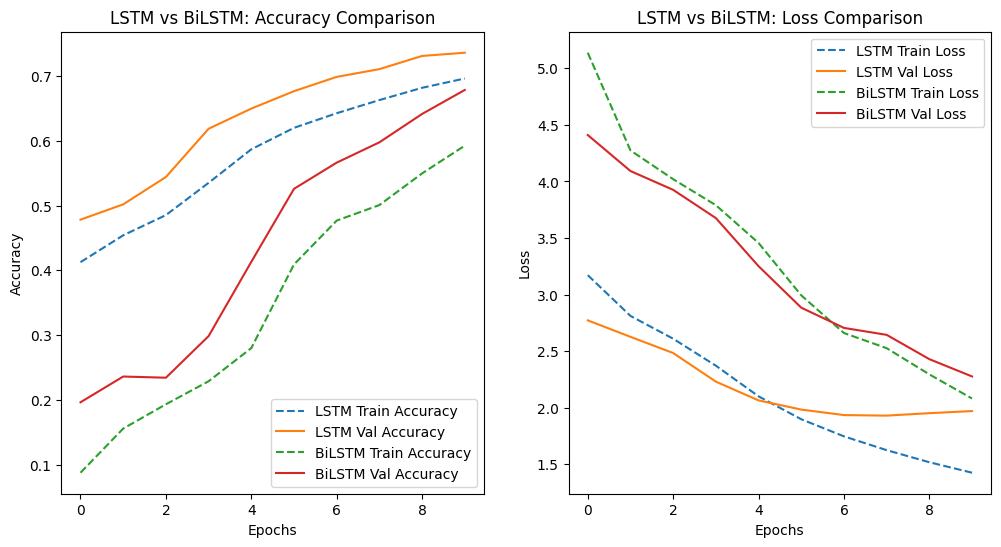

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history["accuracy"], label="LSTM Train Accuracy", linestyle="--")
plt.plot(history_lstm.history["val_accuracy"], label="LSTM Val Accuracy", linestyle="-")
plt.plot(history_bilstm.history["accuracy"], label="BiLSTM Train Accuracy", linestyle="--")
plt.plot(history_bilstm.history["val_accuracy"], label="BiLSTM Val Accuracy", linestyle="-")
plt.title("LSTM vs BiLSTM: Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history["loss"], label="LSTM Train Loss", linestyle="--")
plt.plot(history_lstm.history["val_loss"], label="LSTM Val Loss", linestyle="-")
plt.plot(history_bilstm.history["loss"], label="BiLSTM Train Loss", linestyle="--")
plt.plot(history_bilstm.history["val_loss"], label="BiLSTM Val Loss", linestyle="-")
plt.title("LSTM vs BiLSTM: Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [96]:
print(history_lstm.history.keys())
print(history_bilstm.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
